In [1]:
# !pip install -U imbalanced-learn
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [72]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string, re
import nltk
from nltk import word_tokenize
import spacy
from nltk.stem.porter import PorterStemmer

from imblearn.over_sampling import SMOTE



from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score



import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import LSTM
from keras.backend import clear_session

In [29]:
nltk.download('punkt')
string.punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
news = fetch_20newsgroups(subset='all')

In [31]:
def fetch_data(data, slope=1000):

    remainder = slope
    data_l = []
    batches = len(data.data) // slope + 1

    for i in range(batches):

        x = i * slope

        if i == batches - 1:
            remainder = len(data.data) % slope
        
        datas = np.c_[data.data[x:x + remainder], data.target[x:x + remainder]]
        data_l.append(pd.DataFrame(datas, columns=['text', 'target']))
    
    return pd.concat(data_l)

In [32]:
df = fetch_data(news)

In [33]:
def preprocess(df, col_name='text'):
    
    column = df[col_name].tolist()
    puncs = string.punctuation
    sp = spacy.load('en_core_web_sm')
    stp_wrds = sp.Defaults.stop_words
    txt = ''
    stemmer = PorterStemmer()
    result = []

    for each_txt in column:
        txt = each_txt.lower()
        txt = re.sub(r'\n', ' ', txt)
        txt = re.sub(r'\s{2,}', ' ', txt)
        mytable = txt.maketrans('', '', puncs)
        txt = txt.translate(mytable)
        tokens = txt.split(' ')
        tokens = [word for word in tokens if not word in stp_wrds]
        tokens = [word for word in tokens if  word.isalpha()]
        tokens = [stemmer.stem(each) for each in tokens]
        result.append(' '.join(tokens))

    df['Cleaned_' + col_name] = result
    return df

In [34]:
df = preprocess(df, 'text')

In [35]:
df.head()

,text,target,Cleaned_text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,mamatha devineni ratnam subject pen fan reacti...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,mblawsonmidwayecnuoknoredu matthew b lawson su...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,hilmierdsvsus hilmi eren subject armenia say s...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,guydaustinibmcom guy dawson subject ide vs scs...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,alexand samuel mcdiarmid subject driver organ ...


In [36]:
X, y = df.Cleaned_text, df.target
sm = SMOTE()

tfidf = TfidfVectorizer()
tfidf.fit(X, y)

X_vec = tfidf.transform(X)
X_sm, y_sm = sm.fit_resample(X_vec, y)

x_tr, x_ts, y_tr, y_ts = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm)

In [37]:
def fit_model(X, x_train, x_test, y_train, y_test, report=True, draw_heatmap=True):

    model = X
    model.fit(x_train, y_train)

    pred = model.predict(x_test)
    
    if report:
        print(classification_report(list(y_test), pred))
        
    if draw_heatmap:
        print()
        matrix = confusion_matrix(list(y_test), pred)

        sns.set()
        plt.figure(figsize = (15, 15))

        sns.heatmap(matrix.T,
                    square = True,
                    annot = True,
                    fmt = 'd',
                    cbar = False,
                    linewidths = .9,
                    xticklabels = np.unique(y_train).tolist(),
                    yticklabels = np.unique(y_train).tolist())

        plt.xlabel('Truth')
        plt.ylabel('Predicted')

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       200
           1       0.85      0.85      0.85       200
          10       0.97      0.99      0.98       199
          11       0.88      0.94      0.91       200
          12       0.85      0.83      0.84       199
          13       0.96      0.94      0.95       200
          14       0.94      0.94      0.94       200
          15       0.90      0.95      0.92       200
          16       0.85      0.97      0.91       199
          17       0.98      0.95      0.97       200
          18       0.89      0.92      0.90       200
          19       0.90      0.79      0.84       200
           2       0.86      0.90      0.88       200
           3       0.72      0.82      0.77       200
           4       0.86      0.86      0.86       200
           5       0.90      0.89      0.89       200
           6       0.94      0.70      0.81       200
           7       0.95    

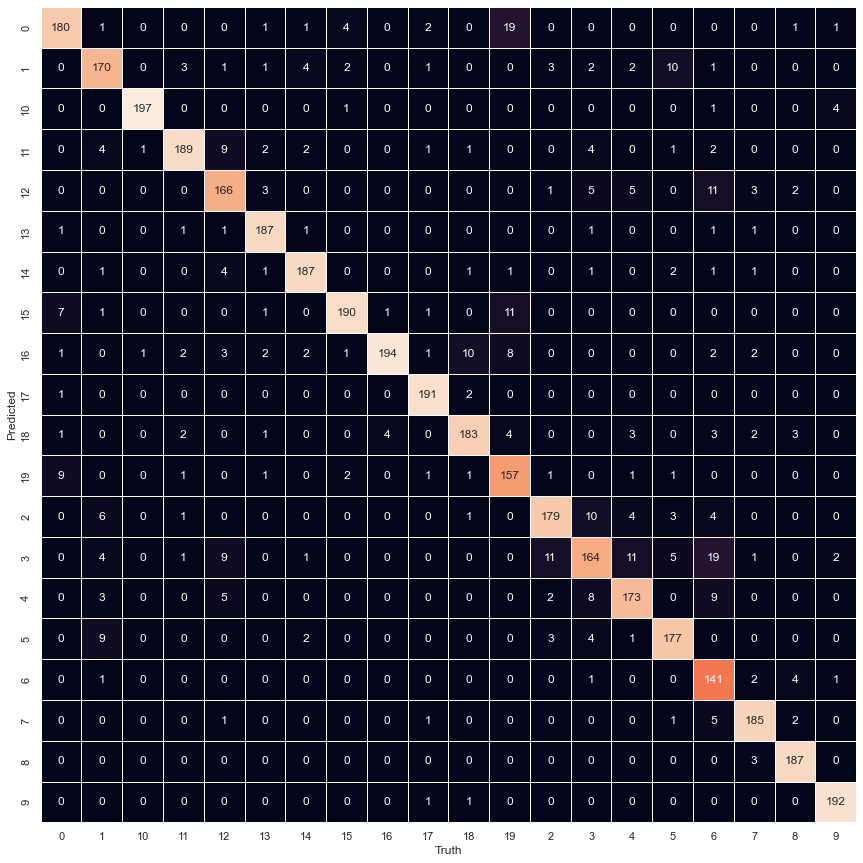

In [38]:
fit_model(MultinomialNB(), x_tr, x_ts, y_tr, y_ts)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       200
           1       0.80      0.90      0.85       200
          10       0.98      0.98      0.98       199
          11       0.98      0.92      0.95       200
          12       0.83      0.86      0.85       199
          13       0.93      0.97      0.95       200
          14       0.97      0.94      0.95       200
          15       0.94      0.89      0.92       200
          16       0.96      0.94      0.95       199
          17       0.98      0.93      0.96       200
          18       0.89      0.94      0.91       200
          19       0.89      0.89      0.89       200
           2       0.82      0.87      0.85       200
           3       0.77      0.78      0.77       200
           4       0.88      0.87      0.87       200
           5       0.85      0.88      0.86       200
           6       0.82      0.81      0.81       200
           7       0.92    

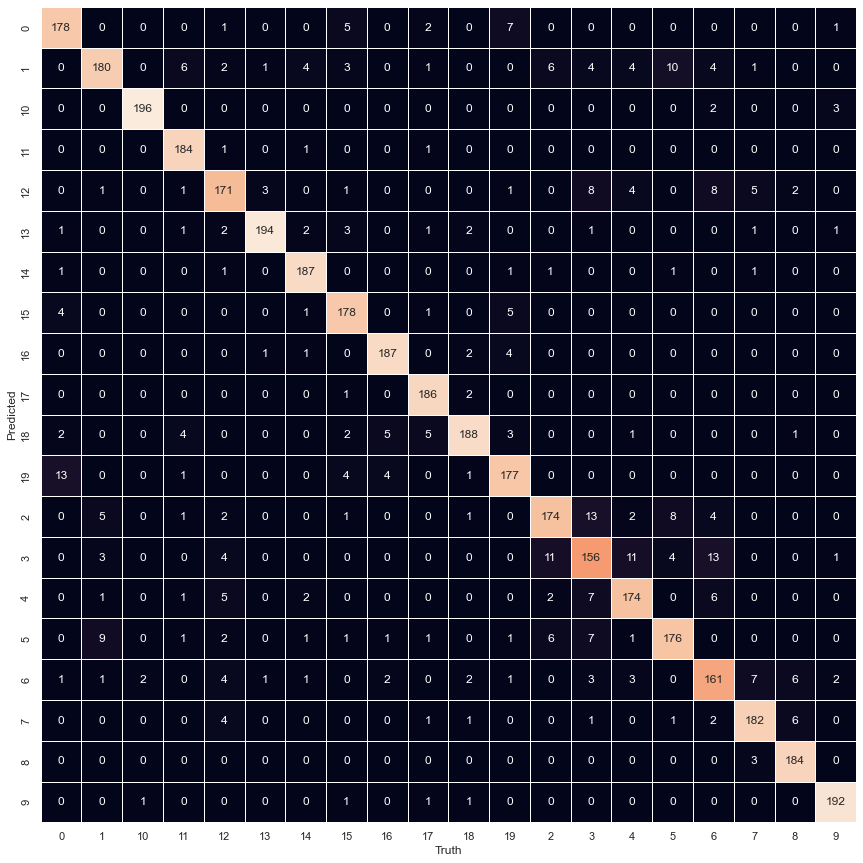

In [39]:
fit_model(LogisticRegression(solver='newton-cg', class_weight='balanced'), x_tr, x_ts, y_tr, y_ts)

In [40]:
X, y = df.Cleaned_text, df.target.astype(int)

text_train, text_test, target_train, target_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [41]:
MAX_WORDS = 10000
MAX_SEQUENCES = 1000


keras_tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(text_train)

word_index = keras_tokenizer.word_index
vocab_size = len(word_index)
train_sequences = keras_tokenizer.texts_to_sequences(text_train)
train_sequences_padded = pad_sequences(train_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

test_sequences = keras_tokenizer.texts_to_sequences(text_test)
test_sequences_padded = pad_sequences(test_sequences, maxlen = MAX_SEQUENCES, padding='post', truncating='post')

In [42]:
train_sequences_padded = np.array(train_sequences_padded)
target_train = np.array(target_train)

test_sequences_padded = np.array(test_sequences_padded)
target_test = np.array(target_test)

In [53]:
def make_NN(x_train, x_test, y_train, y_test, vocab_size, embedding_dim=64, epochs=50):

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=MAX_SEQUENCES),
    # tf.keras.layers.Bidirectional(LSTM(128)),
    tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    print()

    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.25,
                    batch_size=128)
    
    predicted_texts = model.predict(x_test)
    print()

    loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    clear_session()

    return history, predicted_texts

In [54]:
hist, pred = make_NN(train_sequences_padded, test_sequences_padded, target_train, target_test, vocab_size=vocab_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          5588224   
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

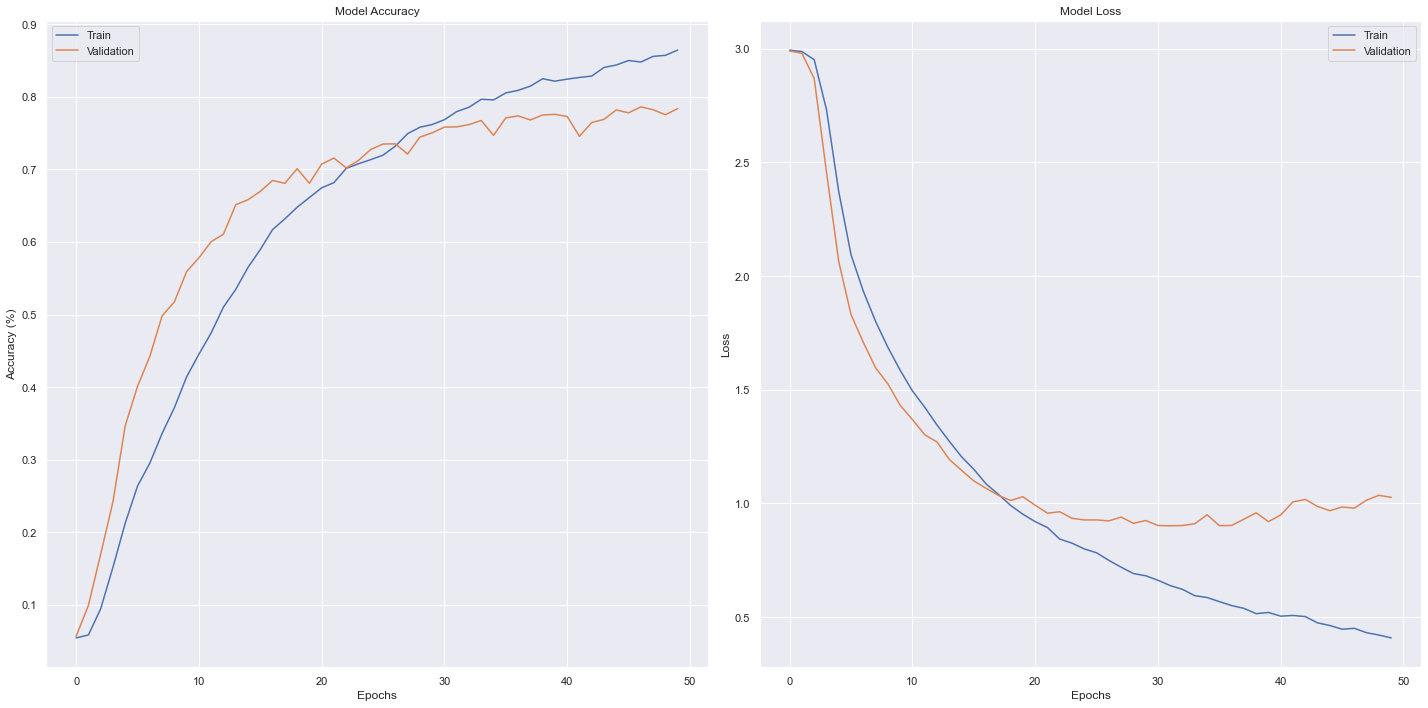

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

hist_df = pd.DataFrame(hist.history)

df_loss = hist_df[['loss', 'val_loss']].copy(deep=True)
df_acc = hist_df[['accuracy', 'val_accuracy']].copy(deep=True)

df_acc.rename(columns={'accuracy': 'Train', 'val_accuracy': 'Validation'}, inplace=True)
df_loss.rename(columns={'loss': 'Train', 'val_loss': 'Validation'}, inplace=True)

ax_acc = df_acc.plot(ax=ax1, figsize=(20, 10), title='Model Accuracy')
ax_loss = df_loss.plot(ax=ax2, figsize=(20, 10), title='Model Loss')

ax_acc.set_xlabel("Epochs")
ax_acc.set_ylabel("Accuracy (%)")

ax_loss.set_xlabel("Epochs")
ax_loss.set_ylabel("Loss")

fig.tight_layout()

In [68]:
target_test.shape

(3770,)

In [69]:
predicted = [np.argmax(pred[i]) for i in range(pred.shape[0])]
# y_test2 = [np.argmax(target_test[i]) for i in range(target_test.shape[0])]

Text(111.5, 0.5, 'Predicted')

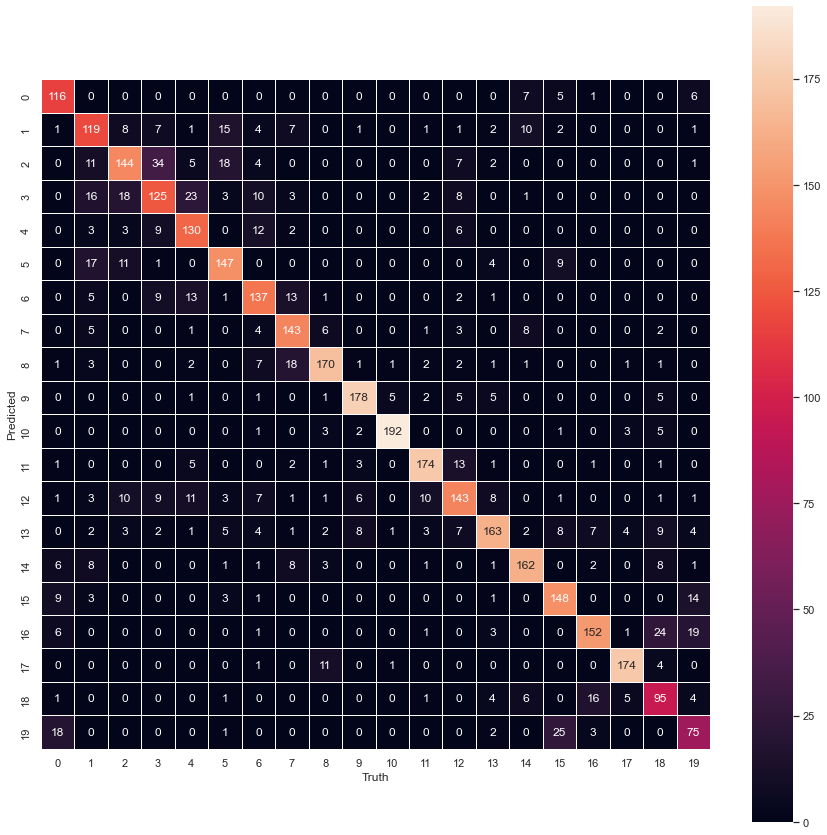

In [85]:
matrix = confusion_matrix(list(target_test), predicted)

sns.set()
plt.figure(figsize = (15, 15))

sns.heatmap(matrix.T,
            square = True,
            annot = True,
            fmt = 'd',
            cbar = True,
            linewidths = .9,
            xticklabels = np.unique(target_train).tolist(),
            yticklabels = np.unique(target_train).tolist())

plt.xlabel('Truth')
plt.ylabel('Predicted')